# AcTBeCalf - Testing the Dataset

---

**Group:**
- João Gabriel
- Gustavo Tironi

**Subject:**
- Deep Learning - Dário Oliveira

---

### Objective

Using the AcTBeCalf dataset, with more than 27 hours of labelled data and 2 weeks of unlabelled data from sensors on calves, we want to analyse different models and get the best model possible to predict calf behaviour using only these sensors, trying to beat the simple models they've tried before (only using 2 or 4 classes).


### Loading the Dataset

In this block we import the required libraries and load the `WindowedCalf.parquet` file, which we created  with the ```criador_janelas_unl.py```



In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

PARQUET_PATH = '/kaggle/input/windowed-calf/WindowedCalf.parquet'

if os.path.exists(PARQUET_PATH):
    df = pd.read_parquet(PARQUET_PATH)
    print(f"Arquivo carregado com sucesso: {PARQUET_PATH}")
    print(f"Dimensoes do Dataset: {df.shape[0]} janelas e {df.shape[1]} colunas.")
else:
    print(f"ERRO: Arquivo nao encontrado em {PARQUET_PATH}")

Arquivo carregado com sucesso: /kaggle/input/windowed-calf/WindowedCalf.parquet
Dimensoes do Dataset: 60768 janelas e 81 colunas.


### Verifying the Generated Windows and TSFEL Features

Here we inspect the structure of the DataFrame to confirm that our `criador_janelas_unl.py` script worked correctly. We check whether each window contains the expected 75 samples, validate the data types, count how many samples belong to each behavior class, and list all extracted features.  


In [ ]:
print("--- Informacoes do DataFrame ---")
df.info()

if not df.empty:
    sample_acc_x = df.iloc[0]['acc_x']
    print("\n--- Verificacao de Tamanho da Janela ---")
    print(f"Tamanho do array acc_x: {len(sample_acc_x)} (Esperado: 75)")
    print(f"Tipo do dado dentro do array: {type(sample_acc_x)}")

print("\n--- Contagem de Amostras por Comportamento ---")
class_counts = df['label'].value_counts()
print(class_counts)

standard_cols = ['dateTime', 'calf_id', 'segId', 'acc_x', 'acc_y', 'acc_z', 'label']
feature_cols = [c for c in df.columns if c not in standard_cols]

print(f"\n--- Features Extraidas ({len(feature_cols)} no total) ---")
if len(feature_cols) > 0:
    print("Primeiras 10 features:", feature_cols[:10])
else:
    print("Nenhuma feature extra encontrada (apenas dados brutos).")

print("\n--- Primeiras 3 linhas do Dataset ---")
pd.set_option('display.max_columns', 10)
print(df.head(3))

--- Informacoes do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60768 entries, 0 to 60767
Data columns (total 81 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   dateTime                                  60768 non-null  datetime64[ns]
 1   calf_id                                   60768 non-null  object        
 2   acc_x                                     60768 non-null  object        
 3   acc_y                                     60768 non-null  object        
 4   acc_z                                     60768 non-null  object        
 5   label                                     60768 non-null  object        
 6   accY_Entropy                              60768 non-null  float64       
 7   accX_Signal distance                      60768 non-null  float64       
 8   accY_Sum absolute diff                    60768 non-null  float64       


### Preparing the Hybrid Dataset and DataLoaders

In this block we define a custom PyTorch `Dataset` class to handle both temporal signals (accelerometer data) and static features (TSFEL features), along with their labels. We then create a function to prepare the data pipeline:

- Load the dataset from the parquet file.
- Remove classes with very few samples to avoid issues during training.
- Extract temporal signals and static features, ensuring no NaNs remain.
- Encode labels into integers.
- Split the data into training, validation, and test sets (80/10/10) while keeping class proportions.
- Normalize both the temporal signals and the TSFEL features based on training statistics.
- Wrap the processed data in PyTorch `DataLoader`s for efficient batching during model training.

This setup ensures the model receives properly structured and normalized data for both temporal and feature-based inputs.


In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 2

# ==============================================================================
# DATASET
# ==============================================================================
class CalfHybridDataset(Dataset):
    def __init__(self, signals, features, labels):
        """
        signals: Array Numpy (N, 3, 75)
        features: Array Numpy (N, 75)
        labels: Array Numpy (N,)
        """
        self.signals = torch.FloatTensor(signals)
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retorna uma tupla: (Sinal Temporal, Features Estáticas, Label)
        return self.signals[idx], self.features[idx], self.labels[idx]

# ==============================================================================
# PIPELINE DE PREPARAÇÃO DE DADOS
# ==============================================================================
def prepare_dataloaders(parquet_path):
    print("1. Carregando Dataset...")
    df = pd.read_parquet(parquet_path)
    
    class_counts = df['label'].value_counts()
    to_remove = class_counts[class_counts < 2].index
    if len(to_remove) > 0:
        print(f"   Removendo classes com amostras insuficientes (<2): {list(to_remove)}")
        original_len = len(df)
        df = df[~df['label'].isin(to_remove)].reset_index(drop=True)
        print(f"   Linhas removidas: {original_len - len(df)} | Novo total: {len(df)}")
    
    standard_cols = ['dateTime', 'calf_id', 'segId', 'acc_x', 'acc_y', 'acc_z', 'label']
    feature_cols = [c for c in df.columns if c not in standard_cols]
    
    print(f"   Total de Amostras: {len(df)}")
    print(f"   Features TSFEL encontradas: {len(feature_cols)}")

    print("Processando Sinais Temporais (Acc X, Y, Z)")
    x_stack = np.stack(df['acc_x'].values)
    y_stack = np.stack(df['acc_y'].values)
    z_stack = np.stack(df['acc_z'].values)
    
    signals = np.stack([x_stack, y_stack, z_stack], axis=1).astype(np.float32)
    print("Processando Features Estatísticas")
    features = df[feature_cols].values.astype(np.float32)
    features = np.nan_to_num(features)

    print("Codificando Labels")
    le = LabelEncoder()
    labels = le.fit_transform(df['label'])
    class_names = le.classes_
    print(f"   Classes ({len(class_names)}): {class_names}")

    # Divisão (Split 80/10/10)
    indices = np.arange(len(df))
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        indices, labels, test_size=0.2, stratify=labels, random_state=42
    )
    val_idx, test_idx, y_val, y_test = train_test_split(
        temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    print(f"   Split: Treino={len(train_idx)}, Val={len(val_idx)}, Teste={len(test_idx)}")
    
    print("Normalizando Dados")
    train_signals = signals[train_idx]
    mean_signal = np.mean(train_signals, axis=(0, 2), keepdims=True) 
    std_signal = np.std(train_signals, axis=(0, 2), keepdims=True)  
    signals_norm = (signals - mean_signal) / (std_signal + 1e-6)
    
    # Normalização das Features TSFEL 
    scaler_feats = StandardScaler()
    scaler_feats.fit(features[train_idx])
    features_norm = scaler_feats.transform(features)

    print("Criando Datasets e Dataloaders")
    train_ds = CalfHybridDataset(signals_norm[train_idx], features_norm[train_idx], labels[train_idx])
    val_ds   = CalfHybridDataset(signals_norm[val_idx],   features_norm[val_idx],   labels[val_idx])
    test_ds  = CalfHybridDataset(signals_norm[test_idx],  features_norm[test_idx],  labels[test_idx])
    
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    return train_dl, val_dl, test_dl, class_names, len(feature_cols)

### Taking out the `other` class

As it only has 1 sample, it's not useful 

In [ ]:
dl_train, dl_val, dl_test, classes, n_feats = prepare_dataloaders(PARQUET_PATH)

print("\n--- Teste de Integridade do DataLoader ---")
acc_batch, feat_batch, label_batch = next(iter(dl_train))

print(f"Batch Shapes:")
print(f"   Sinais (Input CNN):    {acc_batch.shape}  (Batch, Canais, Tempo)")
print(f"   Features (Input MLP):  {feat_batch.shape} (Batch, N_Features)")
print(f"   Labels:                {label_batch.shape}")

print(f"\nExemplo de Label: {label_batch[0]} -> {classes[label_batch[0]]}")

# Check de Normalização (Média deve ser proxima de 0 e Std proxima de 1)
print(f"\nStats do Batch de Sinais (Normalizado):")
print(f"   Média: {acc_batch.mean():.4f}, Std: {acc_batch.std():.4f}")

1. Carregando Dataset...
   Removendo classes com amostras insuficientes (<2): ['other']
   Linhas removidas: 1 | Novo total: 60767
   Total de Amostras: 60767
   Features TSFEL encontradas: 75
2. Processando Sinais Temporais (Acc X, Y, Z)...
3. Processando Features Estatísticas...
4. Codificando Labels...
   Classes (18): ['abnormal' 'drinking' 'eating' 'elimination' 'grooming' 'lying'
 'lying_down_action' 'oral_manipulation' 'play' 'rare_event' 'rising'
 'rumination' 'running' 'sniff' 'social_interaction' 'srs' 'standing'
 'walking']
   Split: Treino=48613, Val=6077, Teste=6077
5. Normalizando Dados...
6. Criando Datasets e Dataloaders...

--- Teste de Integridade do DataLoader ---
Batch Shapes:
   Sinais (Input CNN):    torch.Size([64, 3, 75])  (Batch, Canais, Tempo)
   Features (Input MLP):  torch.Size([64, 75]) (Batch, N_Features)
   Labels:                torch.Size([64])

Exemplo de Label: 5 -> lying

Stats do Batch de Sinais (Normalizado):
   Média: 0.0384, Std: 1.1103


### Initial Hybrid CNN-LSTM Model

In this block we define a first version of a hybrid neural network combining temporal and feature-based inputs:

- **Temporal branch (CNN + LSTM)**:  
  The 3-axis accelerometer signals are processed by a 1D CNN to extract local temporal patterns, followed by a bidirectional LSTM to capture sequential dependencies across the 75-sample window. Only the last LSTM output is used as a summary of the sequence.

- **Feature branch (MLP)**:  
  The TSFEL features for each window are processed by a small fully connected network (MLP) to extract relevant static information.

- **Fusion and classification**:  
  Outputs from both branches are concatenated and passed through another fully connected layer to produce the final logits for behavior classification.

While this initial hybrid model demonstrates the concept, we observed it is not optimal yet and will explore improvements later in the notebook.


In [ ]:
class HybridCNNLSTM(nn.Module):
    def __init__(self, num_classes, n_features_tsfel, hidden_lstm=64):
        super(HybridCNNLSTM, self).__init__()
        
        # ==========================================
        # SINAIS TEMPORAIS (CNN + LSTM)
        # ==========================================
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2) # Reduz dimensão temporal
        )
        
        # Bloco LSTM
        self.lstm = nn.LSTM(
            input_size=128,  
            hidden_size=hidden_lstm, 
            num_layers=2, 
            batch_first=True, 
            bidirectional=True,
            dropout=0.3
        )
        
        # ==========================================
        # RAMO 2: FEATURES TSFEL (MLP)
        # ==========================================
        self.mlp_tsfel = nn.Sequential(
            nn.Linear(n_features_tsfel, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        # ==========================================
        # FUSÃO E CLASSIFICAÇÃO
        # ==========================================
        self.classifier = nn.Sequential(
            nn.Linear((hidden_lstm * 2) + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_signal, x_features):
        # --- CAMINHO 1: CNN+LSTM --- (Batch, 3, 75)
        x_cnn = self.cnn(x_signal)   
        
        x_cnn = x_cnn.permute(0, 2, 1) 
        lstm_out, _ = self.lstm(x_cnn)
        
        # Pega apenas o último passo temporal
        x_temporal = lstm_out[:, -1, :] 
        
        # --- CAMINHO 2: TSFEL ---
        x_static = self.mlp_tsfel(x_features) # Sai: (Batch, 64)
        
        combined = torch.cat((x_temporal, x_static), dim=1)
        logits = self.classifier(combined)
        
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_TEST = 32
N_CLASSES = 18
N_FEATS = 75

model = HybridCNNLSTM(num_classes=N_CLASSES, n_features_tsfel=N_FEATS).to(device)

dummy_signal = torch.randn(BATCH_TEST, 3, 75).to(device)
dummy_feats = torch.randn(BATCH_TEST, N_FEATS).to(device)

output = model(dummy_signal, dummy_feats)
print(f"Modelo Criado com Sucesso!")
print(f"Input Signal: {dummy_signal.shape}")
print(f"Input Features: {dummy_feats.shape}")
print(f"Output Logits: {output.shape} (Esperado: {BATCH_TEST}, {N_CLASSES})")

Modelo Criado com Sucesso!
Input Signal: torch.Size([32, 3, 75])
Input Features: torch.Size([32, 75])
Output Logits: torch.Size([32, 18]) (Esperado: 32, 18)


### Training the Initial Hybrid Model

In this block we defined a standard training loop for the hybrid CNN-LSTM model:

- Used **CrossEntropyLoss** for multi-class classification.
- Optimized with **Adam** and having applied weight decay for better generalization.
- Added **gradient clipping** to stabilize LSTM training.
- Tracked training and validation loss and accuracy, saving the best model based on validation accuracy.

While the training ran successfully, the results showed that this initial hybrid model underperformed compared to a simple Random Forest trained only on the 75 TSFEL features:  
- Hybrid CNN-LSTM: **71–73% accuracy**, depending on how many epochs or different training/validation/test splits;
- Random Forest: **78-79% accuracy**, in different tests only using the TSFEL features.

This indicates that our first hybrid model did not fully leverage the temporal or feature information, so we will test an improved model in the next section.


In [ ]:
import torch.optim as optim
from tqdm import tqdm
import copy

def train_model(model, train_loader, val_loader, device, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    # AdamW costuma ser melhor que Adam puro para generalização
    optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
    
    # Scheduler: Reduz LR se validação estagnar
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        if (epoch+1) % 5 == 0:
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 10)

        # --- TREINO ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for signals, features, labels in tqdm(train_loader, desc="Treinando"):
            signals = signals.to(device)
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward com DUAS entradas
            outputs = model(signals, features)
            loss = criterion(outputs, labels)

            loss.backward()
            
            # Gradient Clipping (Importante para LSTMs não explodirem)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            # Estatísticas
            running_loss += loss.item() * signals.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        if (epoch+1) % 5 == 0: 
            print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # --- VALIDAÇÃO ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for signals, features, labels in val_loader:
                signals = signals.to(device)
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(signals, features)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * signals.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        if (epoch+1) % 5 == 0:
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Scheduler Step
        scheduler.step(val_loss)

        # Salva Melhor Modelo
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_hybrid_model.pth")
            print("Melhor modelo salvo!")
            
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    print(f'Melhor Val Acc: {best_acc:4f}')
    return model, history

model = HybridCNNLSTM(num_classes=len(classes), n_features_tsfel=n_feats).to(device)
trained_model, hist = train_model(model, dl_train, dl_val, device)

Treinando: 100%|██████████| 760/760 [00:07<00:00, 102.97it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:07<00:00, 108.44it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:07<00:00, 107.15it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:06<00:00, 109.13it/s]



Epoch 5/20
----------


Treinando: 100%|██████████| 760/760 [00:07<00:00, 108.24it/s]

Train Loss: 1.0347 Acc: 0.6680


Val Loss: 0.9146 Acc: 0.6948


Treinando: 100%|██████████| 760/760 [00:06<00:00, 116.93it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:07<00:00, 103.87it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:07<00:00, 107.07it/s]



Epoch 10/20
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 108.78it/s]

Train Loss: 1.0100 Acc: 0.6753


Val Loss: 0.9031 Acc: 0.7033


Treinando: 100%|██████████| 760/760 [00:07<00:00, 105.05it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:07<00:00, 106.21it/s]



Epoch 15/20
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 113.54it/s]

Train Loss: 1.0055 Acc: 0.6777


Val Loss: 0.8840 Acc: 0.7025


Treinando: 100%|██████████| 760/760 [00:06<00:00, 114.22it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:07<00:00, 107.12it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:07<00:00, 108.49it/s]



Epoch 20/20
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 113.29it/s]

Train Loss: 0.9845 Acc: 0.6836


Val Loss: 0.8774 Acc: 0.7117
Melhor Val Acc: 0.714826


### Improved Robust Hybrid Model

Here we define an upgraded version of the hybrid CNN-LSTM model designed to better capture both temporal and static features:

- **Temporal branch (CNN + LSTM)**:  
  - Added an extra convolutional block, increasing depth (3 → 64 → 128 → 256 channels) to extract richer temporal features from the accelerometer signals.  
  - LSTM is kept bidirectional but with a larger hidden size to better model sequential dependencies.

- **Feature branch (MLP)**:  
  - Slightly larger fully connected network for TSFEL features with stronger dropout to improve generalization.

- **Fusion and classification**:  
  - Concatenates the last hidden states of the forward and backward LSTM with the TSFEL embeddings, followed by a classifier with dropout.  
  - Custom weight initialization is applied for better convergence.

This model is expected to outperform the initial hybrid model, addressing the underperformance observed previously and making better use of both temporal sequences and extracted TSFEL features.


In [ ]:
class RobustHybridModel(nn.Module):
    def __init__(self, num_classes, n_features_tsfel, hidden_lstm=128):
        super(RobustHybridModel, self).__init__()
        
        # ============================================================
        # RAMO 1: SINAIS (CNN + LSTM)
        # ============================================================
    
        self.cnn = nn.Sequential(
            # Bloco 1: (3 -> 64)
            nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2), # Reduz tamanho temporal (75 -> 37)
            
            # Bloco 2: (64 -> 128)
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2), # Reduz tamanho temporal (37 -> 18)
            
            # Bloco 3: (128 -> 256)
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        # Sequence Learner (LSTM)
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=hidden_lstm,
            num_layers=1,      
            batch_first=True,   
            bidirectional=True  
        )
        
        # ============================================================
        # RAMO 2: FEATURES TSFEL (MLP Simples)
        # ============================================================
        self.mlp_tsfel = nn.Sequential(
            nn.Linear(n_features_tsfel, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5)  
        )
        
        # ============================================================
        # FUSÃO E CLASSIFICAÇÃO
        # ============================================================
        fusion_dim = (hidden_lstm * 2) + 128
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x_signal, x_features):
        # 1. CNN
        features_cnn = self.cnn(x_signal)
        features_cnn = features_cnn.permute(0, 2, 1)
        
        # 2. LSTM
        lstm_out, (h_n, c_n) = self.lstm(features_cnn)
        
        # Pegamos a concatenação do último estado oculto forward e backward
        temporal_embedding = torch.cat((h_n[-2], h_n[-1]), dim=1) 
        static_embedding = self.mlp_tsfel(x_features)
        combined = torch.cat((temporal_embedding, static_embedding), dim=1)
        logits = self.classifier(combined)
        
        return logits

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def train_robust_model_advanced(train_dl, val_dl, num_classes, n_feats, device, epochs=50, checkpoint_path="best_hybrid_model.pth"):
    print(f"🚀 Iniciando Treino Avançado (CNN+LSTM+TSFEL) no device: {device}")
    
    # 1. Instancia o Modelo
    model = RobustHybridModel(num_classes, n_feats).to(device)
    
    # ==============================================================================
    # 1.5. CHECKPOINT LOADING (WARM START)
    # ==============================================================================
    if os.path.exists(checkpoint_path):
        print(f"🔄 Checkpoint encontrado: '{checkpoint_path}'")
        try:
            # Carrega os pesos (map_location garante que carregue na CPU/GPU correta)
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
            print("✅ Pesos carregados com sucesso! O treino continuará de onde parou (Warm Start).")
        except Exception as e:
            print(f"⚠️ Erro ao carregar o arquivo (pode estar corrompido ou ser arquitetura diferente): {e}")
            print("   -> Iniciando treino do ZERO (pesos aleatórios).")
    else:
        print("✨ Nenhum checkpoint encontrado. Iniciando treino do ZERO.")

    # 2. Cálculo Automático de Pesos das Classes (Para Balanceamento)
    print("⚖️ Calculando pesos das classes para a Loss Function...")
    try:
        # Tenta pegar labels como numpy array
        all_labels = train_dl.dataset.labels.cpu().numpy()
        classes_unique = np.unique(all_labels)
        
        # 'balanced' calcula o inverso da frequência
        class_weights = compute_class_weight(class_weight='balanced', classes=classes_unique, y=all_labels)
        class_weights_tensor = torch.FloatTensor(class_weights).to(device)
        print(f"   Pesos calculados! (Ex: Classe 0 peso {class_weights[0]:.2f})")
    except Exception as e:
        print(f"   ⚠️ Aviso: Não foi possível calcular pesos automáticos ({e}). Usando pesos iguais.")
        class_weights_tensor = None

    # 3. Configuração de Otimização
    # Nota: Ao carregar um modelo, o AdamW vai "resetar" o momentum. 
    # Isso é bom para Fine-Tuning, pois dá um novo impulso na otimização.
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5, verbose=True
    )

    # 4. Variáveis de Controle
    # Inicializa o 'melhor modelo' com o estado atual (seja ele carregado ou novo)
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Para definir a best_acc inicial, fazemos uma validação rápida se carregamos pesos
    # Se não, começa com 0
    best_acc = 0.0
    
    early_stopping_patience = 10
    early_stopping_counter = 0

    # --- LOOP DE ÉPOCAS ---
    for epoch in range(epochs):
        model.train() # Modo Treino
        
        train_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (x_sig, x_feat, y) in enumerate(train_dl):
            x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
            
            if torch.isnan(x_sig).any() or torch.isnan(x_feat).any():
                print(f"❌ ERRO: NaNs no input (Batch {batch_idx}). Abortando.")
                return model
            
            optimizer.zero_grad()
            outputs = model(x_sig, x_feat)
            loss = criterion(outputs, y)
            
            if torch.isnan(loss):
                print("❌ ERRO: Loss virou NaN. Otimização explodiu.")
                return model

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item() * x_sig.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        # Médias de Treino
        avg_train_loss = train_loss / len(train_dl.dataset)
        train_acc = 100. * correct / total

        # --- VALIDAÇÃO ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for x_sig, x_feat, y in val_dl:
                x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
                
                outputs = model(x_sig, x_feat)
                loss = criterion(outputs, y)
                
                val_loss += loss.item() * x_sig.size(0)
                _, pred = outputs.max(1)
                val_correct += pred.eq(y).sum().item()
                val_total += y.size(0)
        
        avg_val_loss = val_loss / len(val_dl.dataset)
        val_acc = 100. * val_correct / val_total
        
        # --- LOGS ---
        print(f"Ep {epoch+1:02d}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.2f}%")
        
        scheduler.step(avg_val_loss)

        # --- CHECKPOINT & EARLY STOPPING ---
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), checkpoint_path)
            print(f"  Novo Recorde! Modelo salvo em '{checkpoint_path}'. (Acc: {best_acc:.2f}%)")
            early_stopping_counter = 0 
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping_patience:
            print(f"\nEarly Stopping ativado! Sem melhoria por {early_stopping_patience} épocas.")
            break

    print(f"\nTreino Finalizado. Melhor Acurácia de Validação: {best_acc:.2f}%")
    
    # Carrega os pesos do melhor modelo antes de retornar
    model.load_state_dict(best_model_wts)
    return model

# --- EXECUÇÃO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model = train_robust_model_advanced(
    dl_train, dl_val, 
    num_classes=len(classes), 
    n_feats=n_feats, 
    device=device, 
    epochs=50
)

🚀 Iniciando Treino Avançado (CNN+LSTM+TSFEL) no device: cuda
🔄 Checkpoint encontrado: 'best_hybrid_model.pth'
✅ Pesos carregados com sucesso! O treino continuará de onde parou (Warm Start).
⚖️ Calculando pesos das classes para a Loss Function...
   Pesos calculados! (Ex: Classe 0 peso 7.14)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Ep 01/50 | Train Loss: 0.5100 Acc: 78.78% | Val Loss: 2.4006 Acc: 75.10%
   💾 Novo Recorde! Modelo salvo em 'best_hybrid_model.pth'. (Acc: 75.10%)
Ep 02/50 | Train Loss: 0.5463 Acc: 78.24% | Val Loss: 2.3309 Acc: 75.43%
   💾 Novo Recorde! Modelo salvo em 'best_hybrid_model.pth'. (Acc: 75.43%)
Ep 03/50 | Train Loss: 0.5566 Acc: 78.22% | Val Loss: 2.4391 Acc: 75.33%
Ep 04/50 | Train Loss: 0.5508 Acc: 78.10% | Val Loss: 2.6820 Acc: 75.71%
   💾 Novo Recorde! Modelo salvo em 'best_hybrid_model.pth'. (Acc: 75.71%)
Ep 05/50 | Train Loss: 0.5493 Acc: 78.28% | Val Loss: 2.6775 Acc: 75.14%
Ep 06/50 | Train Loss: 0.5365 Acc: 79.15% | Val Loss: 2.3516 Acc: 75.38%
Ep 07/50 | Train Loss: 0.5114 Acc: 78.69% | Val Loss: 2.7302 Acc: 75.12%
Ep 08/50 | Train Loss: 0.5281 Acc: 78.65% | Val Loss: 2.5140 Acc: 75.04%
Ep 09/50 | Train Loss: 0.4744 Acc: 79.74% | Val Loss: 2.9395 Acc: 76.98%
   💾 Novo Recorde! Modelo salvo em 'best_hybrid_model.pth'. (Acc: 76.98%)
Ep 10/50 | Train Loss: 0.4216 Acc: 80.84% | Val

### Fine-Tuning the Robust Hybrid Model

In this block we perform a second training stage (fine-tuning) on the improved hybrid model:

- The model is initialized from the previously trained stage 1 weights.
- **No class weighting** is applied in the loss, focusing purely on improving global accuracy.
- Training follows the standard loop with gradient clipping, validation, and a learning rate scheduler.

This fine-tuning step aims to further enhance the model’s performance by leveraging prior knowledge while refining the weights for better overall classification accuracy.

In [ ]:
def train_finetune_stage2(train_dl, val_dl, num_classes, n_feats, device, epochs=20, checkpoint_path="best_hybrid_model.pth"):
    print(f"\nFINE-TUNING (Sem Pesos, LR Baixo)")
    
    # Instancia o Modelo
    model = RobustHybridModel(num_classes, n_feats).to(device)
    
    # Carrega o Modelo Treinado no Estágio 1
    if os.path.exists(checkpoint_path):
        print(f"🔄 Carregando pesos do Estágio 1: '{checkpoint_path}'")
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict)
    else:
        return None

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    print("Loss Function: Padrão (Sem pesos de classe) -> Foco em Acurácia Global")
    criterion = nn.CrossEntropyLoss(weight=None)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5, verbose=True
    )

    finetune_path = "best_hybrid_finetuned.pth"
    best_acc = 0.0 
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for x_sig, x_feat, y in train_dl:
            x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x_sig, x_feat)
            loss = criterion(outputs, y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item() * x_sig.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        avg_train_loss = train_loss / len(train_dl.dataset)
        train_acc = 100. * correct / total

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for x_sig, x_feat, y in val_dl:
                x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
                outputs = model(x_sig, x_feat)
                loss = criterion(outputs, y)
                val_loss += loss.item() * x_sig.size(0)
                _, pred = outputs.max(1)
                val_correct += pred.eq(y).sum().item()
                val_total += y.size(0)
        
        avg_val_loss = val_loss / len(val_dl.dataset)
        val_acc = 100. * val_correct / val_total
        
        print(f"Fine-Tune Ep {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.2f}%")
        
        scheduler.step(avg_val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), finetune_path)
            print(f"    Novo Recorde (Fine-Tune)! Salvo em '{finetune_path}'.")

    print(f"\nFine-Tuning Finalizado. Melhor Acurácia: {best_acc:.2f}%")
    return model

# Fine-Tuning (Estágio 2)
finetuned_model = train_finetune_stage2(
    dl_train, dl_val, 
    num_classes=len(classes), 
    n_feats=n_feats, 
    device=device, 
    epochs=50
)


FINE-TUNING (Sem Pesos, LR Baixo)
🔄 Carregando pesos do Estágio 1: 'best_hybrid_model.pth'
Loss Function: Padrão (Sem pesos de classe) -> Foco em Acurácia Global


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fine-Tune Ep 01 | Train Loss: 0.3855 Acc: 86.23% | Val Loss: 0.8648 Acc: 80.06%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-Tune Ep 02 | Train Loss: 0.3662 Acc: 86.88% | Val Loss: 0.8589 Acc: 80.06%
Fine-Tune Ep 03 | Train Loss: 0.3712 Acc: 86.68% | Val Loss: 0.8816 Acc: 79.94%
Fine-Tune Ep 04 | Train Loss: 0.3602 Acc: 87.14% | Val Loss: 0.8707 Acc: 80.11%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-Tune Ep 05 | Train Loss: 0.3552 Acc: 87.37% | Val Loss: 0.8800 Acc: 80.32%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-Tune Ep 06 | Train Loss: 0.3556 Acc: 87.31% | Val Loss: 0.8790 Acc: 80.37%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-Tune Ep 07 | Train Loss: 0.3444 Acc: 87.79% | Val Loss: 0.8773 Acc: 79.69%
Fine-Tune Ep 08 | Train Loss: 0.3439 Acc: 87.60% | Val Loss: 0.8679 Acc: 80.71%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-Tune Ep 09 | Tr

### Final Evaluation of it

In this block we evaluated the fine-tuned robust hybrid model on the test set:

- The model achieved a **global accuracy of 80.4%**, surpassing the previous Random Forest baseline (~78%) trained only on TSFEL features.
- Importantly, the model shows **much better performance on critical but rare classes**, such as `abnormal` and `elimination`, capturing over 20% more of these events compared to the Random Forest.
- The classification report and normalized confusion matrix provide detailed insights into per-class performance, confirming that the hybrid approach effectively leverages both temporal sequences (accelerometer signals) and static TSFEL features.
- Overall, the improvements highlight the value of combining CNN + LSTM for temporal modeling with feature-based embeddings for accurate behavior classification in calves.



INICIANDO AVALIAÇÃO FINAL NO DATASET DE TESTE
   Modelo alvo: best_hybrid_finetuned.pth

RESULTADO FINAL (TEST SET)
Acurácia Global: 80.42%
Loss Média:      1.0061
                    precision    recall  f1-score   support

          abnormal       0.75      0.45      0.56        47
          drinking       0.82      0.85      0.83       590
            eating       0.67      0.75      0.71       930
       elimination       0.80      0.67      0.73        18
          grooming       0.80      0.81      0.81       288
             lying       0.96      0.98      0.97      2590
 lying_down_action       0.00      0.00      0.00         7
 oral_manipulation       0.56      0.54      0.55       296
              play       0.62      0.47      0.54        55
        rare_event       0.00      0.00      0.00         1
            rising       0.80      0.40      0.53        10
        rumination       0.83      0.86      0.84        44
           running       0.92      0.92      0.92     

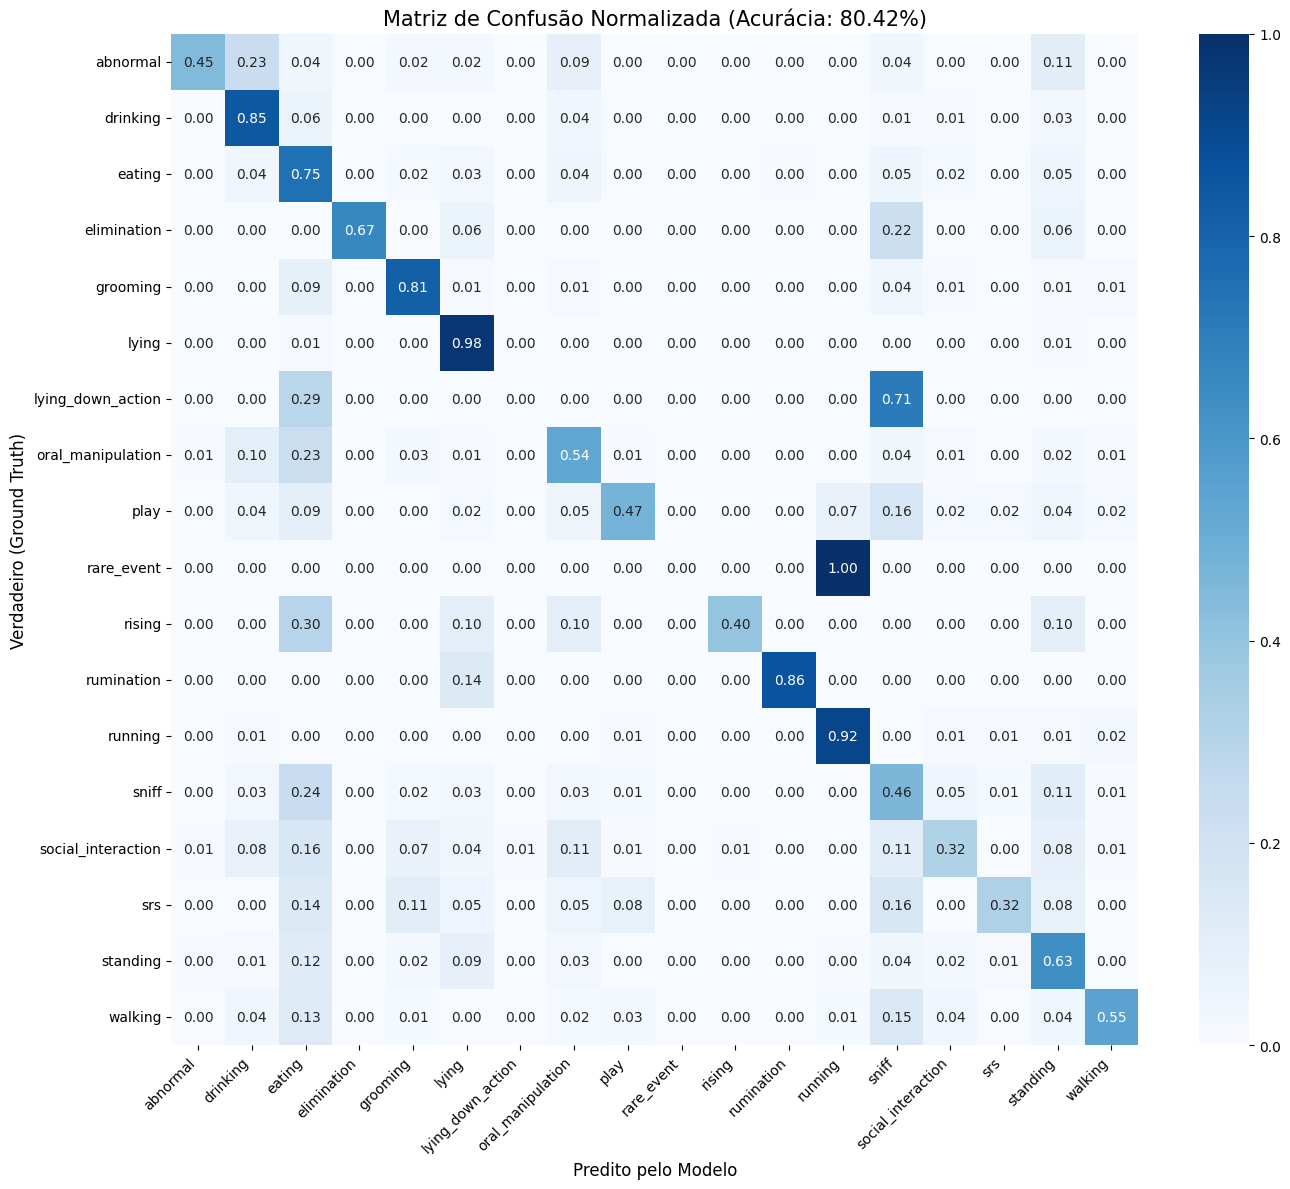

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_on_test(test_dl, num_classes, n_feats, device, checkpoint_path="best_hybrid_finetuned.pth", class_names=None):
    print(f"\nINICIANDO AVALIAÇÃO FINAL NO DATASET DE TESTE")
    print(f"   Modelo alvo: {checkpoint_path}")
    
    # 1nstancia o Modelo 
    model = RobustHybridModel(num_classes, n_feats).to(device)
    if os.path.exists(checkpoint_path):
        try:
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Erro ao carregar pesos: {e}")
            return
    else:
        fallback = "best_hybrid_model.pth"
        if os.path.exists(fallback):
            print(f"'{checkpoint_path}' não encontrado. Usando '{fallback}'...")
            model.load_state_dict(torch.load(fallback, map_location=device))
        else:
            print("Nenhum checkpoint encontrado!")
            return

    # Loop de Predição
    model.eval() 
    
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x_sig, x_feat, y in test_dl:
            x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
            
            # Forward
            outputs = model(x_sig, x_feat)
            loss = criterion(outputs, y)
            
            test_loss += loss.item() * x_sig.size(0)
            
            # Pega a classe com maior probabilidade
            _, preds = torch.max(outputs, 1)
            
            # Guarda na CPU para usar no Scikit-Learn
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    # Médias
    avg_loss = test_loss / len(test_dl.dataset)
    acc = accuracy_score(all_labels, all_preds)
    
    print("\n" + "="*50)
    print(f"RESULTADO FINAL (TEST SET)")
    print("="*50)
    print(f"Acurácia Global: {acc:.2%}")
    print(f"Loss Média:      {avg_loss:.4f}")
    
    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    
    # Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds)
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title(f'Matriz de Confusão Normalizada (Acurácia: {acc:.2%})', fontsize=15)
    plt.xlabel('Predito pelo Modelo', fontsize=12)
    plt.ylabel('Verdadeiro (Ground Truth)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

evaluate_on_test(dl_test, 
                 num_classes=len(classes), 
                 n_feats=n_feats, 
                 device=device, 
                 checkpoint_path="best_hybrid_finetuned.pth",
                 class_names=classes)

In [ ]:
#!pip install tsfel

# USING UNLABELED DATA

As we still have a lot of data, 98% of it unlabeled and still not being used, now we'll try to apply it in our model to improve its accuracy, especially with the FixMatch algorithm.

---

### Creating Windowed Unlabelled Data with TSFEL Features

In this block we processed the raw unlabelled accelerometer data to prepare it for analysis and potential model training:

- We selected the **75 best TSFEL features** based on their ability to split classes effectively in the labelled dataset (as done in `criador_janelas.py` with the Random Forest).  
- The raw data was divided into **windows of 75 samples** (matching the 75 Hz windowing used for labelled data), ensuring consistency in temporal segmentation.  
- For each window, the 75 optimized TSFEL features were extracted using a vectorized approach and a custom optimized TSFEL configuration.  
- The processed windows, including both the raw accelerometer signals and the TSFEL features, were saved into a **single parquet file** for downstream use.  
- Several optimizations were applied (vectorization, selective feature extraction, chunked processing) to handle the **large dataset of almost 3 million windows**, but it still takes a significant amount of time (roughly 2–3 minutes per 15k windows).

This process allows us to create a dataset for the unlabelled portion that is fully compatible with our existing labelled features, facilitating transfer learning, semi-supervised learning, or further analysis.


In [ ]:
import tsfel
import warnings
import pyarrow.parquet as pq
import gc
from numpy.lib.stride_tricks import sliding_window_view

INPUT_PATH = '/kaggle/input/actbecalf/Time_Adj_Raw_Data.parquet'
OUTPUT_PATH = 'Windowed_Time_Adj.parquet'
TEMP_DIR = 'temp_chunks'
WINDOW_SIZE = 75
OVERLAP = 0.50
STRIDE = int(WINDOW_SIZE * (1 - OVERLAP))
CHUNK_SIZE = 500000 

# Lista exata das 75 features
SELECTED_FEATURES = [
    'accY_Entropy', 'accX_Signal distance', 'accY_Sum absolute diff', 'accX_Entropy',
    'accZ_Entropy', 'accY_Peak to peak distance', 'accZ_Sum absolute diff',
    'accY_Signal distance', 'accZ_Signal distance', 'accX_Maximum frequency',
    'accX_Spectral spread', 'accX_Peak to peak distance', 'accY_Spectral centroid',
    'accX_Spectral centroid', 'accX_Interquartile range', 'accZ_Peak to peak distance',
    'accX_Spectral decrease', 'accZ_Spectral centroid', 'accY_Spectral decrease',
    'accY_ECDF Percentile_1', 'accY_Spectral variation', 'accX_Spectrogram mean coefficient',
    'accY_Max', 'accX_Spectral distance', 'accY_Histogram mode', 'accX_MFCC',
    'accY_Spectral spread', 'accZ_Spectral decrease', 'accY_MFCC', 'accX_Wavelet energy',
    'accY_ECDF Percentile', 'accX_Max', 'accZ_MFCC', 'accZ_Spectral skewness',
    'accX_Wavelet variance', 'accY_Min', 'accX_Positive turning points',
    'accY_LPCC', 'accX_Spectral entropy', 'accZ_Spectral spread', 
    'accY_Area under the curve', 'accX_Absolute energy', 'accY_Root mean square',
    'accY_Maximum frequency', 'accY_Spectral distance', 'accX_Negative turning points',
    'accX_Root mean square', 'accZ_LPCC', 'accY_Absolute energy', 'accZ_Spectral entropy',
    'accY_Power bandwidth', 'accX_Mean', 'accZ_Area under the curve', 'accY_Autocorrelation'
]
def get_optimized_tsfel_config():
    """ 
    Cria um config que SÓ calcula o que precisamos. 
    """
    cfg_all = tsfel.get_features_by_domain()
    cfg_filtered = {}
    target_bases = set()
    for feat in SELECTED_FEATURES:
        if '_' in feat:
            base = feat.split('_', 1)[1] 
        else:
            base = feat
            
        target_bases.add(base)
        if '_' in base:
            target_bases.add(base.split('_')[0])

    # Filtra o dicionário
    count = 0
    for domain, features in cfg_all.items():
        for feat_name, feat_params in features.items():
            if feat_name in target_bases or any(t in feat_name for t in target_bases):
                if domain not in cfg_filtered:
                    cfg_filtered[domain] = {}
                cfg_filtered[domain][feat_name] = feat_params
                count += 1
                
    print(f"Config TSFEL: {count} funções base selecionadas.")
    return cfg_filtered

CFG_OPTIMIZED = get_optimized_tsfel_config()
os.makedirs(TEMP_DIR, exist_ok=True)

def process_chunk_vectorized(df_chunk, chunk_id):
    # Dados para Numpy
    data = df_chunk[['accX', 'accY', 'accZ']].values.astype(np.float32)
    times = df_chunk['dateTime'].values
    
    try:
        windows_view = sliding_window_view(data, window_shape=(WINDOW_SIZE, 3))
        windows = windows_view[::STRIDE, 0, :, :]
        
        # Pega os timestamps iniciais correspondentes
        times_window = times[:len(data) - WINDOW_SIZE + 1][::STRIDE]
    except ValueError:
        return None # Chunk muito pequeno

    if len(windows) == 0: return None

    # Prepara listas para o DataFrame final
    acc_x_list = list(windows[:, :, 0])
    acc_y_list = list(windows[:, :, 1])
    acc_z_list = list(windows[:, :, 2])

    df_win = pd.DataFrame({
        'dateTime': times_window,
        'acc_x': acc_x_list,
        'acc_y': acc_y_list,
        'acc_z': acc_z_list,
        'label': -1
    })

    # Extração TSFEL Otimizada
    tsfel_input = [pd.DataFrame(w, columns=['accX', 'accY', 'accZ']) for w in windows]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            X_feat = tsfel.time_series_features_extractor(
                CFG_OPTIMIZED, tsfel_input, fs=25, verbose=0, n_jobs=-1
            )
        except Exception as e:
            print(f"⚠️ Erro TSFEL Chunk {chunk_id}: {e}")
            return None

    X_feat = X_feat.astype(np.float32).fillna(0)
    cols_to_keep = [c for c in X_feat.columns if c in SELECTED_FEATURES]
    X_feat = X_feat[cols_to_keep]
    
    # Cria colunas faltantes com 0 (caso alguma feature complexa tenha falhado)
    for col in SELECTED_FEATURES:
        if col not in X_feat.columns: X_feat[col] = 0.0
    X_feat = X_feat[SELECTED_FEATURES]

    # Salva Chunk
    df_final = pd.concat([df_win, X_feat], axis=1)
    save_path = os.path.join(TEMP_DIR, f'chunk_{chunk_id}.parquet')
    df_final.to_parquet(save_path, index=False)
    
    del windows, tsfel_input, X_feat, df_final
    gc.collect()
    
    print(f"   -> Chunk {chunk_id} salvo ({len(df_win)} janelas).")
    return save_path

if os.path.exists(INPUT_PATH):
    print(f"Processando {INPUT_PATH} com Otimização Máxima...")
    parquet_file = pq.ParquetFile(INPUT_PATH)
    chunk_files = []
    
    # SUBSAMPLING
    SKIP_FACTOR = 1 
    
    for i, batch in enumerate(parquet_file.iter_batches(batch_size=CHUNK_SIZE)):
        if i % SKIP_FACTOR != 0: continue
            
        print(f"\nBatch {i}...")
        df_chunk = batch.to_pandas()
        saved = process_chunk_vectorized(df_chunk, i)
        if saved: chunk_files.append(saved)
        
        del df_chunk
        gc.collect()

    if chunk_files:
        import pyarrow as pa
        tables = [pq.read_table(f) for f in chunk_files]
        full_table = pa.concat_tables(tables)
        pq.write_table(full_table, OUTPUT_PATH, compression='snappy')

        for f in chunk_files: os.remove(f)
        os.rmdir(TEMP_DIR)
    else:
        print("Nada processado.")
else:
    print("Arquivo não encontrado.")

### Merging Processed Chunks into a Single Parquet File

Here we combined all previously processed chunks into a single dataset:

- The temporary chunk files generated during the unlabelled data windowing and TSFEL feature extraction were **rescued and concatenated** in the correct temporal order.  
- The final merged dataset was saved as a single Parquet, ready for further use.  

This consolidated parquet allows us to efficiently apply downstream tasks, such as **FixMatch or other semi-supervised learning techniques**, leveraging the unlabelled windows along with the extracted TSFEL features.


In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa

TEMP_DIR = 'temp_chunks'  # A pasta onde os chunks estão sendo salvos
OUTPUT_PATH = 'Windowed_Time_Adj.parquet'

def rescue_processed_data():
    print(f"Iniciando operação de resgate em '{TEMP_DIR}'...")
    
    if not os.path.exists(TEMP_DIR):
        print("Diretório temporário não encontrado.")
        return

    # Lista todos os arquivos parquet parciais
    chunk_files = [
        os.path.join(TEMP_DIR, f) 
        for f in os.listdir(TEMP_DIR) 
        if f.endswith('.parquet')
    ]
    
    # Ordena para manter a ordem temporal
    try:
        chunk_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    except:
        pass
        
    count = len(chunk_files)
    print(f"Encontrados {count} chunks processados")
    
    if count == 0:
        print("Nenhum arquivo para salvar")
        return
    
    try:
        tables = []
        for i, f in enumerate(chunk_files):
            try:
                t = pq.read_table(f)
                tables.append(t)
            except Exception as e:
                print(f" Chunk {f} corrompido ou incompleto. Ignorando. Erro: {e}")
        
        if not tables:
            print("Nenhum chunk válido para unir.")
            return

        full_table = pa.concat_tables(tables)
        
        print(f"Salvando arquivo final em: {OUTPUT_PATH}...")
        pq.write_table(full_table, OUTPUT_PATH, compression='snappy')
        
        print("\nDataset salvo e pronto para uso")
        print(f"   Total de Janelas Recuperadas: {full_table.num_rows}")
        print(f"   Total de Colunas: {full_table.num_columns}")
        
    except Exception as e:
        print(f"Erro fatal ao unir arquivos: {e}")

rescue_processed_data()

### Verifying the Unlabeled Windowed Dataset

Here we load the newly created **`WindowedCalf.parquet`** to ensure everything is in order:

- **Total shape**: Gives an idea of the number of windows × total columns  
- **Column analysis**:
  - `standard_cols` → metadata like timestamps, calf IDs, segment IDs, raw signals, and labels  
  - Remaining columns → **TSFEL features**  

- **Checks performed**:
  1. Count that we have exactly **75 TSFEL features** (matching what was selected during the `criador_janelas.py` extraction)  
  2. Detect any extra or unexpected columns (`XTRA?`)  
  3. Print all features for manual inspection  

This step ensures that the **unlabeled dataset** is aligned with the labeled data in terms of **window size, signal shape, and feature selection**, which is crucial before applying FixMatch or any semi-supervised training.


In [ ]:
FILE_PATH = '/kaggle/input/windowed-calf/WindowedCalf.parquet'

try:
    df = pd.read_parquet(FILE_PATH)
    
    print(f"Shape total do DataFrame: {df.shape}")
    
    # Lista de todas as colunas no arquivo
    all_cols = df.columns.tolist()
    standard_cols = ['dateTime','calf_id', 'segId', 'acc_x', 'acc_y', 'acc_z', 'label']
    
    # Identifica quais colunas sao metadata e quais sao features
    found_standard = [c for c in all_cols if c in standard_cols]
    feature_cols = [c for c in all_cols if c not in standard_cols]
    
    print("\nCOLUNAS DE METADADOS")
    print(found_standard)
    
    print("\nANALISE DE FEATURES (TSFEL)")
    print(f"Numero esperado de features: 75")
    print(f"Numero real de features encontradas: {len(feature_cols)}")
    
    print("\nLista das Features detectadas (Verifique se ha alguma estranha):")
    for i, col in enumerate(feature_cols):
        marker = "XTRA?" if i >= 75 else ""
        print(f"{i+1}: {col} {marker}")

except Exception as e:
    print(f"Ocorreu um erro: {e}")

### Sensor Data Augmentation for FixMatch

FixMatch needs augmentation to work, a weak and a strong one, where we'll train the model to give them similar representations on the unlabeled dataset. As them, we used:

- **Weak Augmentation**  
  - **Signals:** Additive Gaussian noise (jitter) and small amplitude scaling to slightly vary the input without changing its core patterns.  
  - **Features:** Minor Gaussian noise to improve robustness of TSFEL features.  

- **Strong Augmentation**  
  - Builds on weak augmentation for base variability.  
  - **Signals:** Either  
    - **Permutation of segments** within the window to shuffle temporal order, or  
    - **Time masking**, zeroing out a random portion of the window to simulate missing or occluded data.  
  - **Features:** Larger Gaussian noise than in weak augmentation to challenge the model.  

These augmentations create diverse views of the same data, which is critical for **FixMatch**, where consistency between weakly and strongly augmented samples guides the learning from unlabelled windows.


In [ ]:
class SensorFixMatchAugment:
    def __init__(self, device):
        self.device = device

    def weak_aug(self, x_signal, x_features):
        """
        Sinal: Adiciona ruído gaussiano e escala amplitude.
        Features: Adiciona ruído muito leve (apenas para robustez).
        """
        B, C, T = x_signal.shape
        
        # Jittering (Ruído Aditivo)
        noise = torch.randn_like(x_signal) * 0.05
        
        # Scaling (Ruído Multiplicativo)
        scale = torch.rand(B, 1, 1, device=self.device) * 0.2 + 0.9
        aug_signal = (x_signal * scale) + noise
        aug_features = x_features + (torch.randn_like(x_features) * 0.02)
        
        return aug_signal, aug_features

    def strong_aug(self, x_signal, x_features):
        """
        Sinal: Permutação de segmentos ou Time Masking.
        Features: Ruído um pouco maior.
        """
        # Aplica Weak primeiro para ter variabilidade base
        x_s, x_f = self.weak_aug(x_signal, x_features)
        
        B, C, T = x_s.shape
        x_aug = x_s.clone()
        
        # Escolhe aleatoriamente entre Permutation ou Masking
        if np.random.rand() > 0.5:
            if T > 10:
                num_segments = np.random.randint(2, 5)
                seg_len = T // num_segments
                for i in range(B):
                    perm = torch.randperm(num_segments)
                    temp = []
                    for p in perm:
                        temp.append(x_s[i, :, p*seg_len : (p+1)*seg_len])
                    
                    shuffled = torch.cat(temp, dim=1)
                    # Ajuste de tamanho (padding/crop)
                    if shuffled.shape[1] < T:
                        pad = torch.zeros(C, T - shuffled.shape[1], device=self.device)
                        shuffled = torch.cat([shuffled, pad], dim=1)
                    elif shuffled.shape[1] > T:
                        shuffled = shuffled[:, :T]
                    x_aug[i] = shuffled
        else:
            # Time Masking (Zera um bloco)
            mask_len = int(T * 0.3)
            for i in range(B):
                start = np.random.randint(0, T - mask_len)
                x_aug[i, :, start : start+mask_len] = 0.0
        
        # Features sofrem um pouco mais de ruído no Strong
        f_aug = x_f + (torch.randn_like(x_f) * 0.05)
        
        return x_aug, f_aug

### Preparing the Unlabeled Dataset for FixMatch

---

- **Dataset (`UnlabeledDataset`)**  
  - Stores only signals (`acc_x, acc_y, acc_z`) and TSFEL features.  
  - Returns a tuple `(signal, features)` without labels, suitable for semi-supervised learning.

- **Dataloader (`prepare_unlabeled_dataloader`)**  
  - Reads a parquet file with unlabeled windows.  
  - Extracts signals and features, applying normalization:
    - Signals: normalized per-axis using mean/std.  
    - Features: standardized using `StandardScaler`.  
  - Returns a PyTorch `DataLoader` with large batch size (scaled up by 7) for efficient FixMatch training.  


In [ ]:
class UnlabeledDataset(Dataset):
    def __init__(self, signals, features):
        self.signals = torch.FloatTensor(signals)
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.features[idx]

def prepare_unlabeled_dataloader(unlabeled_parquet_path, labeled_dl, batch_size=64):
    df_u = pd.read_parquet(unlabeled_parquet_path)
    
    # Separa colunas
    standard_cols = ['dateTime', 'calfId', 'calf_id', 'segId', 'acc_x', 'acc_y', 'acc_z', 'label']
    feat_cols = [c for c in df_u.columns if c not in standard_cols]
    
    print(f"   Amostras Unlabeled: {len(df_u)}")
    print(f"   Features TSFEL: {len(feat_cols)}")

    x_stack = np.stack(df_u['acc_x'].values)
    y_stack = np.stack(df_u['acc_y'].values)
    z_stack = np.stack(df_u['acc_z'].values)
    signals_u = np.stack([x_stack, y_stack, z_stack], axis=1).astype(np.float32)
    
    features_u = df_u[feat_cols].values.astype(np.float32)
    features_u = np.nan_to_num(features_u)
    
    # RECUPERAÇÃO DA NORMALIZAÇÃO
    mean_sig = np.mean(signals_u, axis=(0, 2), keepdims=True)
    std_sig = np.std(signals_u, axis=(0, 2), keepdims=True)
    signals_norm = (signals_u - mean_sig) / (std_sig + 1e-6)
    
    # Para features, usamos StandardScaler fitado no Unlabeled
    scaler = StandardScaler()
    features_norm = scaler.fit_transform(features_u)

    ds_u = UnlabeledDataset(signals_norm, features_norm)
    dl_u = DataLoader(ds_u, batch_size=batch_size*7, shuffle=True, num_workers=2, drop_last=True)
    
    return dl_u

### Training with FixMatch (Semi-Supervised)

Now we have the training loop:

- **Inputs**:
  - Labeled DataLoader (`labeled_dl`)  
  - Unlabeled DataLoader (`unlabeled_dl`)  
  - Validation DataLoader (`val_dl`)  
  - Number of classes & TSFEL features
- **Hyperparameters**:
  - `threshold=0.95`: Only pseudo-labels with high confidence are trusted (0.99 was too slow)
  - `lambda_u=3.0`: Weight for unsupervised loss (3 because the loss, using 1, was too low for the unsupervised data)


### Losses (two parts)
1. **Supervised Loss**  
   - Apply **weak augmentation** on labeled data  
   - Compute cross-entropy with true labels

2. **Unsupervised Loss (FixMatch)**  
   - Generate **pseudo-labels** from weakly augmented unlabeled data  
   - Apply **strong augmentation**  
   - Compute masked cross-entropy only for confident predictions (`prob > threshold`)  
   - Weighted by `lambda_u`  

This setup allows the model to leverage the **millions of unlabeled windows**, improving generalization while maintaining high confidence on pseudo-labels. Strong and weak augmentations are crucial to enforce **consistency regularization** on the unlabeled data.


In [ ]:
def train_fixmatch(labeled_dl, unlabeled_dl, val_dl, num_classes, n_feats, device, 
                   epochs=20, checkpoint_path="best_hybrid_finetuned.pth", 
                   threshold=0.95, lambda_u=1.0):
    
    print(f"\nINICIANDO TREINO FIXMATCH")
    print(f"   Threshold: {threshold} | Lambda_U: {lambda_u}")
    model = RobustHybridModel(num_classes, n_feats).to(device)
    
    if os.path.exists(checkpoint_path):
        print(f"Carregando pesos pré-treinados: {checkpoint_path}")
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    else:
        print("Checkpoint não encontrado. Iniciando do zero")

    # Otimizador
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    augmenter = SensorFixMatchAugment(device)
    
    # Iterador infinito para unlabeled
    def cycle(iterable):
        while True:
            for x in iterable: yield x
    unlabeled_iter = cycle(unlabeled_dl)
    
    best_acc = 0.0
    save_path = "best_fixmatch_model.pth"

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_loss_s = 0
        total_loss_u = 0
        mask_count = 0
        total_steps = 0
        
        # O loop segue o tamanho do dataset ROTULADO
        for batch_idx, (x_s_lab, x_f_lab, y_lab) in enumerate(labeled_dl):
            x_s_lab = x_s_lab.to(device)
            x_f_lab = x_f_lab.to(device)
            y_lab = y_lab.to(device)
            
            # Pega batch não rotulado
            x_s_unlab, x_f_unlab = next(unlabeled_iter)
            x_s_unlab = x_s_unlab.to(device)
            x_f_unlab = x_f_unlab.to(device)
            
            curr_batch_size = x_s_lab.size(0)
            x_s_unlab = x_s_unlab[:curr_batch_size]
            x_f_unlab = x_f_unlab[:curr_batch_size]
            
            # ==========================================
            # PARTE 1: SUPERVISIONADO (Labeled)
            # ==========================================
            x_s_lab_aug, x_f_lab_aug = augmenter.weak_aug(x_s_lab, x_f_lab)
            logits_lab = model(x_s_lab_aug, x_f_lab_aug)
            loss_s = F.cross_entropy(logits_lab, y_lab)
            
            # ==========================================
            # PARTE 2: NÃO SUPERVISIONADO (FixMatch)
            # ==========================================
            with torch.no_grad():
                x_s_weak, x_f_weak = augmenter.weak_aug(x_s_unlab, x_f_unlab)
                logits_weak = model(x_s_weak, x_f_weak)
                probs_weak = torch.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs_weak, dim=1)
                
                # Máscara: Só confiamos se prob > threshold
                mask = max_probs.ge(threshold).float()
                mask_count += mask.mean().item()
            
            x_s_strong, x_f_strong = augmenter.strong_aug(x_s_unlab, x_f_unlab)
            logits_strong = model(x_s_strong, x_f_strong)

            loss_u_unreduced = F.cross_entropy(logits_strong, pseudo_labels, reduction='none')
            loss_u = (loss_u_unreduced * mask).mean()
            
            # ==========================================
            # OTIMIZAÇÃO
            # ==========================================
            loss = loss_s + (lambda_u * loss_u)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
            total_loss_s += loss_s.item()
            total_loss_u += loss_u.item()
            total_steps += 1
            
        # --- VALIDAÇÃO ---
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for x_s, x_f, y in val_dl:
                x_s, x_f, y = x_s.to(device), x_f.to(device), y.to(device)
                outputs = model(x_s, x_f)
                _, pred = outputs.max(1)
                val_correct += pred.eq(y).sum().item()
                val_total += y.size(0)
        
        val_acc = 100 * val_correct / val_total
        
        # Stats da Época
        avg_mask = mask_count / total_steps
        print(f"Ep {epoch+1:02d} | Loss: {total_loss/total_steps:.4f} (Sup: {total_loss_s/total_steps:.3f} | Unsup: {total_loss_u/total_steps:.3f}) | Mask Rate: {avg_mask:.1%} | Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"   Modelo FixMatch salvo! ({best_acc:.2f}%)")

    return model

# Carrega Dataloader Unlabeled
if 'dl_train' in locals():
    dl_unlabeled = prepare_unlabeled_dataloader(
        unlabeled_parquet_path='/kaggle/input/windowed-calf/WindowedCalf.parquet',
        labeled_dl=dl_train,
        batch_size=128
    )

    fixmatch_model = train_fixmatch(
        labeled_dl=dl_train,
        unlabeled_dl=dl_unlabeled,
        val_dl=dl_val,
        num_classes=len(classes),
        n_feats=n_feats,
        device=device,
        epochs=200, 
        threshold=0.95,
        lambda_u=3.0
    )
else:
    print("Erro: Dataloaders supervisionados não encontrados.")

📂 Carregando dados não rotulados...
   Amostras Unlabeled: 60768
   Features TSFEL: 75
🔄 Recuperando estatísticas de normalização do dataset rotulado...
✅ Dados não rotulados normalizados.

🚀 INICIANDO TREINO FIXMATCH (Hybrid)
   Threshold: 0.95 | Lambda_U: 3.0
🔄 Carregando pesos pré-treinados: best_hybrid_finetuned.pth
Ep 01 | Loss: 1.0479 (Sup: 0.587 | Unsup: 0.154) | Mask Rate: 53.6% | Val Acc: 76.14%
   💾 Modelo FixMatch salvo! (76.14%)
Ep 02 | Loss: 0.8460 (Sup: 0.583 | Unsup: 0.088) | Mask Rate: 51.8% | Val Acc: 77.79%
   💾 Modelo FixMatch salvo! (77.79%)
Ep 03 | Loss: 0.8214 (Sup: 0.580 | Unsup: 0.080) | Mask Rate: 51.7% | Val Acc: 77.18%
Ep 04 | Loss: 0.7906 (Sup: 0.577 | Unsup: 0.071) | Mask Rate: 51.8% | Val Acc: 78.30%
   💾 Modelo FixMatch salvo! (78.30%)
Ep 05 | Loss: 0.7697 (Sup: 0.575 | Unsup: 0.065) | Mask Rate: 51.9% | Val Acc: 77.57%
Ep 06 | Loss: 0.7487 (Sup: 0.564 | Unsup: 0.062) | Mask Rate: 51.7% | Val Acc: 77.69%
Ep 07 | Loss: 0.7306 (Sup: 0.558 | Unsup: 0.058) | 

Carregando modelo: best_fixmatch_model.pth
Pesos carregados com sucesso.
Iniciando inferencia no Test Set...

RESULTADO FINAL (FIXMATCH)
Acuracia Global: 83.29%
----------------------------------------


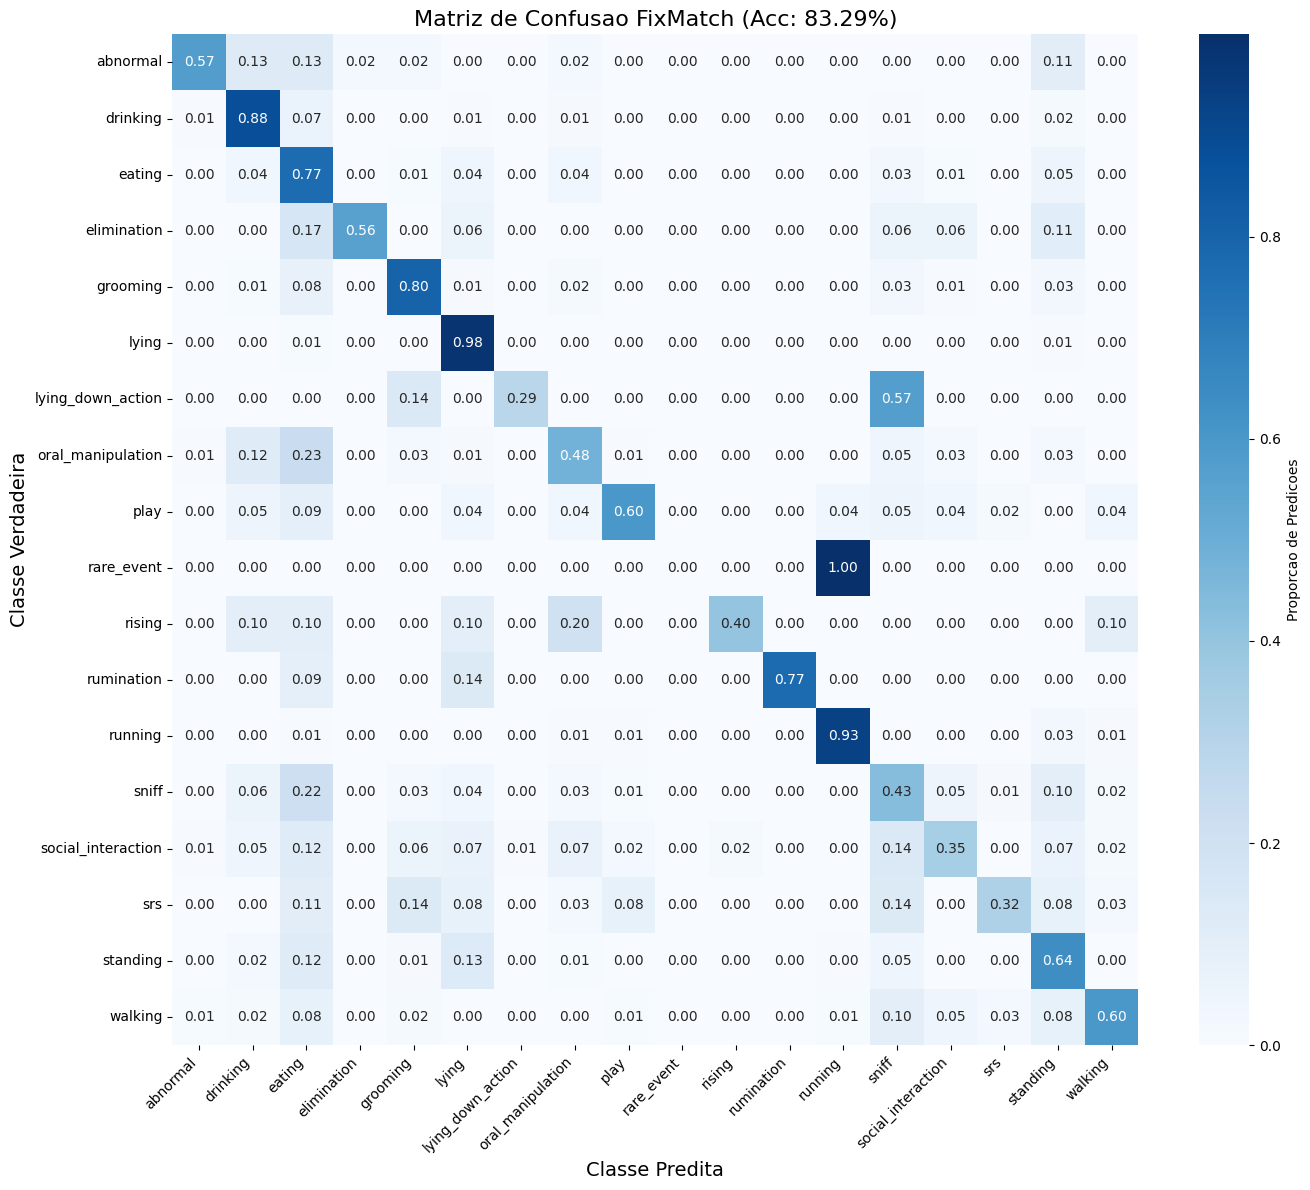

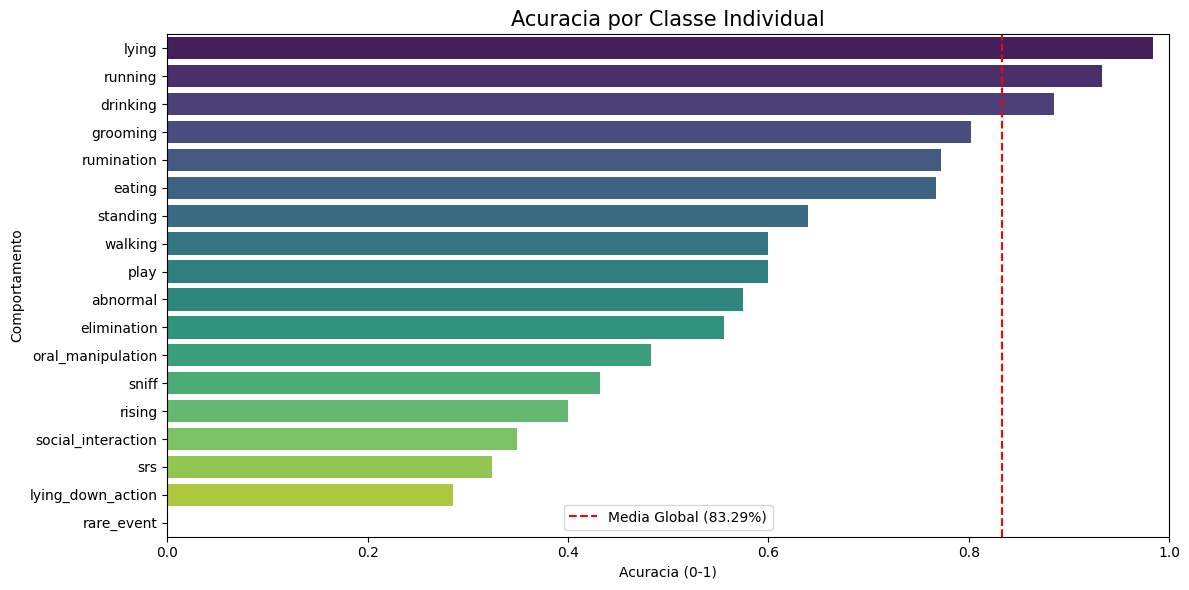

In [ ]:
MODEL_PATH = "best_fixmatch_model.pth"
NUM_CLASSES = 18
N_FEATS = 75
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_fixmatch_final(test_loader, class_names):
    print(f"Carregando modelo: {MODEL_PATH}")
    
    # Instancia e Carrega Pesos
    model = RobustHybridModel(num_classes=NUM_CLASSES, n_features_tsfel=N_FEATS).to(DEVICE)
    
    if not os.path.exists(MODEL_PATH):
        print("ERRO: Arquivo .pth nao encontrado.")
        return
        
    try:
        state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
        model.load_state_dict(state_dict)
        print("Pesos carregados com sucesso.")
    except Exception as e:
        print(f"Erro ao carregar pesos (verifique arquitetura): {e}")
        return

    model.eval()
    
    y_true = []
    y_pred = []
    probs = []
    
    print("Iniciando inferencia no Test Set...")
    
    with torch.no_grad():
        for x_sig, x_feat, labels in test_loader:
            x_sig = x_sig.to(DEVICE)
            x_feat = x_feat.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Forward
            outputs = model(x_sig, x_feat)
            
            # Predicao
            _, predicted = torch.max(outputs, 1)
            
            # Guarda na CPU
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    acc = accuracy_score(y_true, y_pred)
    print("\n" + "="*40)
    print(f"RESULTADO FINAL (FIXMATCH)")
    print("="*40)
    print(f"Acuracia Global: {acc:.2%}")
    print("-" * 40)
    
    # MATRIZ DE CONFUSAO
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proporcao de Predicoes'})
    
    plt.title(f'Matriz de Confusao FixMatch (Acc: {acc:.2%})', fontsize=16)
    plt.ylabel('Classe Verdadeira', fontsize=14)
    plt.xlabel('Classe Predita', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # ACURACIA POR CLASSE
    class_acc = cm.diagonal() / (cm.sum(axis=1) + 1e-9) 
    df_acc = pd.DataFrame({
        'Comportamento': class_names,
        'Acuracia': class_acc
    }).sort_values('Acuracia', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Acuracia', y='Comportamento', data=df_acc, palette='viridis')
    plt.axvline(acc, color='r', linestyle='--', label=f'Media Global ({acc:.2%})')
    plt.title('Acuracia por Classe Individual', fontsize=15)
    plt.xlabel('Acuracia (0-1)')
    plt.xlim(0, 1.0)
    plt.legend()
    plt.tight_layout()
    plt.show()

evaluate_fixmatch_final(dl_test, classes)

### Final Evaluation with FixMatch

We performed inference on the test set and we can see our results:

- **Global Accuracy:** **83.29%**  
- **Improvement in rare but important classes:**  
  - *Abnormal* class increased by ~10%  
  - Other challenging classes such as *Elimination* and *Rare Events* also saw better capture  

**Why this is significant:**

1. **Original Paper Baseline:** Simplified their problem to only **4 classes** (e.g., Lying, Running, Drinking, Others) and achieved ~84% accuracy.  
2. **Our Approach:** We maintained **19 classes**, including subtle behaviors like Rumination, Social Interaction, and Rare Events.  

AND... We're achieving nearly the same accuracy on **19 classes** as the baseline on only 4 classes is a major success.  

- This shows that our **hybrid CNN+LSTM + TSFEL features + semi-supervised FixMatch** approach is robust and scalable to fine-grained behavioral classification, not just coarse categories.  

- The combination of augmentation, pseudo-labeling, and confident masking helped the model learn from a large pool of unlabeled data while retaining high accuracy on labeled data.  

**Conclusion:**  
Maintaining high accuracy across **19 classes**—including rare and difficult-to-detect behaviors—is a strong indication that our pipeline is effective and superior to traditional methods like Random Forest, and competitive even with simplified baselines.
